In [2]:
import numpy as np
import os
import root_numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
eval = pd.read_csv('data/sample_test.csv')

# eval_rows = 1000 * 1000
# rows_to_train = 200 * 1000
# skip_rows_eval = np.random.permutation(eval_rows)[rows_to_train:] + 1
# eval = pd.read_csv('data/data_eval.csv', skiprows=skip_rows_eval)

part_codes = {'Ghost':0, 'Electron':11, 'Muon':13, 'Pion':211, 'Kaon':321, 'Proton':2212}

eval_types = eval['MCParticleType']

mc_features = ['Unnamed: 0', 'HasMC', 'MCParticleType', 'MCParticleP', 'MCParticlePt', 'MCVirtualMass', 
               'MCFromB', 'MCFromD', 'MCVertexType', 'MCVertexX', 'MCVertexY', 'MCVertexZ', 
               'piplus_OWNPV_X', 'piplus_OWNPV_Y', 'piplus_OWNPV_Z', 'piplus_OWNPV_XERR', 
               'piplus_OWNPV_YERR', 'piplus_OWNPV_ZERR', 'piplus_OWNPV_CHI2', 'piplus_OWNPV_NDOF', 
               'piplus_IP_OWNPV', 'piplus_IPCHI2_OWNPV', 'nCandidate', 'totCandidates', 'EventInSequence', 
               'TrackHistory', 'TrackType', 'RecoPIDcode']

constant_features = ['TrackMatchChi2', 'TrackCloneDist', 'RichUsedAero']

eval.drop(mc_features + constant_features, axis=1, inplace=1)
print eval.shape

(100000, 77)


In [5]:
import cPickle as pickle
from sklearn.metrics import roc_curve, roc_auc_score

def test_model(model_type, part_type):
    model = pickle.load(open('models/{0}-{1}.pkl'.format(model_type, part_type), 'rb'))
    
    preds = model.predict_proba(eval)[:, 1]
    true_labels = (eval_types == part_codes[part_type]).astype(int)
    roc_auc = roc_auc_score(true_labels, preds)
    fpr, tpr, _ = roc_curve(true_labels, preds)

    result = {}
    result[part_type] = roc_auc, fpr, tpr

    for other_part in part_codes:
        if other_part == part_type:
            continue
        mask = (eval_types == part_codes[other_part]) | (eval_types == part_codes[part_type])
        true_labels = eval_types[mask] == part_codes[part_type]
        preds_other = preds[np.where(mask)]
        result[other_part] = roc_auc_score(true_labels, preds_other)

    return result

    
rocs_kmlp = {}
for part_type in part_codes:
    print part_type
    rocs_kmlp[part_type] = test_model('kMLP', part_type)
    
rocs_kbdt = {}
for part_type in part_codes:
    print part_type
    rocs_kbdt[part_type] = test_model('kBDT', part_type)
print 'Done!'

Ghost
Muon
Pion
Kaon
Proton
Electron
Ghost
Muon
Pion
Kaon
Proton
Electron
Done!


In [6]:
def plot_auc(rocs, model_name):
    plt.figure(figsize=(12, 8))
    for part_type in part_codes:
        label = '{0}, {1:0.2f}'.format(part_type, rocs[part_type][part_type][0])
        plt.plot(rocs[part_type][part_type][1], rocs[part_type][part_type][2], label=label)
    plt.legend(loc=0, prop={'size':20})
    plt.title('ROC AUC for {0}'.format(model_name))
    
def plot_binary_rocs(rocs, model_name):
    binary_rocs = np.zeros(shape=(6, 6))
    for index, part_type in enumerate(part_codes):
        for jndex, other_part in enumerate(part_codes):
            if index == jndex:
                binary_rocs[index, index] = 1.0
            else:
                binary_rocs[index, jndex] = rocs[part_type][other_part]
                binary_rocs[jndex, index] = rocs[part_type][other_part]
    plt.figure(figsize=(10, 8))
    sns.heatmap(binary_rocs, cmap='RdBu_r', xticklabels=part_codes.keys(), yticklabels=part_codes.keys())
    plt.title('Pairwise AUC for {0}'.format(model_name))

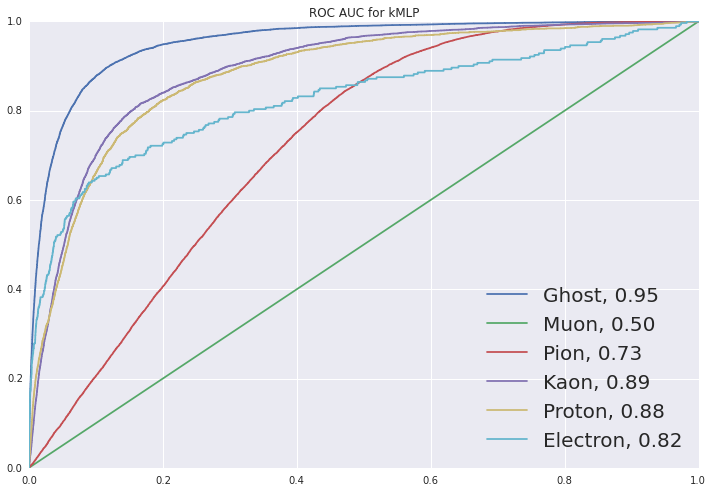

In [7]:
plot_auc(rocs_kmlp, 'kMLP')

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


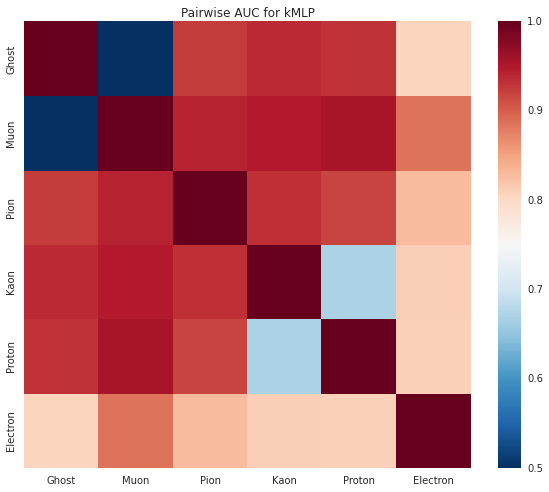

In [8]:
plot_binary_rocs(rocs_kmlp, 'kMLP')

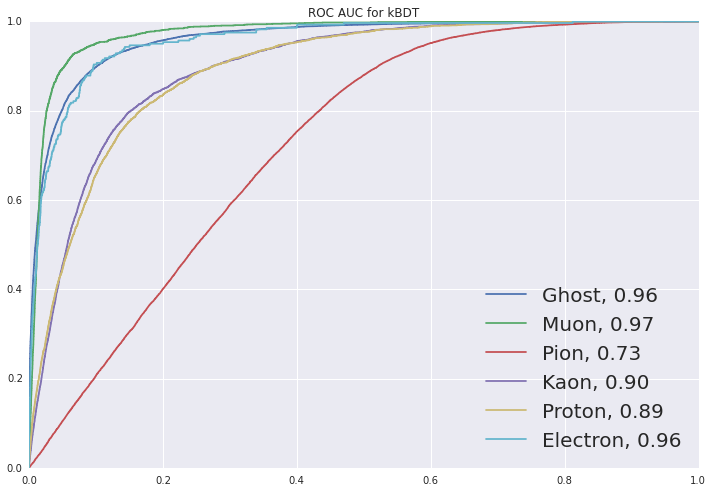

In [9]:
plot_auc(rocs_kbdt, 'kBDT')

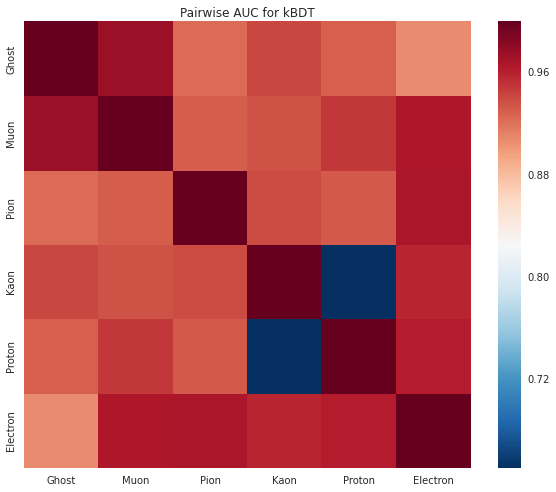

In [25]:
plot_binary_rocs(rocs_kbdt, 'kBDT')